In [1]:
import os
os.chdir("/usr/src/app")
import pandas as pd
from os.path import join as jp
import cv2
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import re

In [2]:
# Path videos
PATH_VIDEOS_DATASET = "videos/tennistv"
PATH_VIDEOS_GS_DATASET = "videos/grand_slams"

# Path annotation
PATH_ANNOTATIONS_REFERENCE = "annotations/reference_courts/annotations.xml"

# <font size=20> Read CVAT Annotations

In [3]:
import xml.etree.ElementTree as ET
import pandas as pd

In [4]:
def parse_img_ref(string):
    pattern = r'ref___l(.*?)___t(.*?)___v(.*?)___f(.*?).png'
    match = re.search(pattern, string)
    
    if match:
        level = match.group(1)
        tourn_id = match.group(2)
        video_id = match.group(3)
        frame_num = match.group(4)
        return level, int(tourn_id), video_id, int(frame_num)
    else:
        return None, None, None, None

def get_path(video_id, level, folder="tennistv"):
    if level == "grandslam":
        folder = "grand_slams"
    # folder can be: tennistv or grand_slams
    path_video_folder = f"videos/{folder}"
    return os.path.join(path_video_folder, f"{video_id}.mp4")   

In [5]:
# Load and parse the XML file
tree = ET.parse(PATH_ANNOTATIONS_REFERENCE)
root = tree.getroot()

In [6]:
# Initialize lists to store the extracted data
image_ids = []
image_names = []
court_points = []
net_points = []

# Iterate through each 'image' element in the XML
for image in root.findall('.//image'):
    # Extract image id and name
    image_id = image.get('id')
    image_name = image.get('name')
    
    # Extract court points as a list of tuples
    court_point_str = image.find('.//points[@label="court"]').get('points')
    court_point_str = court_point_str.split(';')
    court_points_list = [(float(point.split(',')[0]), float(point.split(',')[1])) for point in court_point_str]
    
    # Extract net points as a list of tuples
    net_point_str = image.find('.//box[@label="net"]')
    net_x1 = float(net_point_str.get('xtl'))
    net_y1 = float(net_point_str.get('ytl'))
    net_x2 = float(net_point_str.get('xbr'))
    net_y2 = float(net_point_str.get('ybr'))
    
    net_points_list = [(net_x1, net_y1), (net_x2, net_y1), (net_x2, net_y2), (net_x1, net_y2)]
    
    # Append data to the lists
    image_ids.append(image_id)
    image_names.append(image_name)
    court_points.append(court_points_list)
    net_points.append(net_points_list)

# Create a DataFrame
data = {
    'image_id': image_ids,
    'image_name': image_names,
    'court': court_points,
    'net': net_points
}

df_annot = pd.DataFrame(data)

# Parse the name of the image to get the video_id, tournament_i and frame_id
df_annot[['level', 'tournament_id', 'video_id', 'frame_id']] = pd.DataFrame(df_annot["image_name"].map(parse_img_ref).tolist(), index=df_annot.index)

# Get different paths according to the origin of the youtube channel
df_annot["path_video"] = df_annot.apply(lambda row: get_path(row["video_id"], row["level"]), axis=1)

In [7]:
df_annot

,image_id,image_name,court,net,level,tournament_id,video_id,frame_id,path_video
0,0,ref___l1000___t10___vl6Dx9KzyRig___f2052.png,"[(295.79, 856.88), (465.85, 852.47), (961.68, ...","[(354.32, 415.17), (1574.56, 415.17), (1574.56...",1000,10,l6Dx9KzyRig,2052,videos/tennistv/l6Dx9KzyRig.mp4
1,1,ref___l1000___t11___vLhDFuGXXvGA___f5748.png,"[(299.1, 785.1), (465.9, 786.2), (958.4, 784.0...","[(433.83, 336.76), (1480.7, 336.76), (1480.7, ...",1000,11,LhDFuGXXvGA,5748,videos/tennistv/LhDFuGXXvGA.mp4
2,2,ref___l1000___t12___vrGT0FsEuc3U___f5199.png,"[(356.5, 833.7), (527.7, 837.0), (1013.6, 834....","[(391.87, 420.69), (1636.4, 420.69), (1636.4, ...",1000,12,rGT0FsEuc3U,5199,videos/tennistv/rGT0FsEuc3U.mp4
3,3,ref___l1000___t4___vfnK4I6k9eHs___f29533.png,"[(351.0, 844.7), (506.7, 841.4), (958.4, 842.5...","[(434.9, 420.69), (1474.1, 420.69), (1474.1, 5...",1000,4,fnK4I6k9eHs,29533,videos/tennistv/fnK4I6k9eHs.mp4
4,4,ref___l1000___t5___vRdjN79TWRFQ___f8926.png,"[(387.4, 864.6), (532.1, 864.6), (956.2, 862.4...","[(461.4, 415.2), (1444.3, 415.2), (1444.3, 501...",1000,5,RdjN79TWRFQ,8926,videos/tennistv/RdjN79TWRFQ.mp4
...,...,...,...,...,...,...,...,...,...
60,60,ref___lfinals___t64___vdsALS4dDxDs___f12418.png,"[(320.0, 860.2), (483.4, 857.7), (961.4, 856.6...","[(386.59, 425.7), (1540.5, 425.7), (1540.5, 53...",finals,64,dsALS4dDxDs,12418,videos/tennistv/dsALS4dDxDs.mp4
61,61,ref___lgrandslam___t0___vF9ZGyxlCyBU___f79834.png,"[(199.3, 516.8), (314.2, 517.8), (642.6, 519.9...","[(342.88, 233.0), (933.3, 233.0), (933.3, 300....",grandslam,0,F9ZGyxlCyBU,79834,videos/grand_slams/F9ZGyxlCyBU.mp4
62,62,ref___lgrandslam___t1___vQNgE9-0sNjQ&t___f7025...,"[(232.3, 590.0), (332.8, 585.9), (622.0, 584.9...","[(350.11, 294.9), (902.4, 294.9), (902.4, 355....",grandslam,1,QNgE9-0sNjQ&t,7025,videos/grand_slams/QNgE9-0sNjQ&t.mp4
63,63,ref___lgrandslam___t2___vdvBr9Wr8BCY___f1611.png,"[(113.7, 598.3), (247.2, 594.2), (629.2, 593.2...","[(287.17, 288.71), (978.7, 288.71), (978.7, 36...",grandslam,2,dvBr9Wr8BCY,1611,videos/grand_slams/dvBr9Wr8BCY.mp4


# <font size=20> Visualize annotations

In [26]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [27]:
def get_frame(cap, frame_num):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    
    # Read the frame
    ret, frame = cap.read()

    return frame

In [28]:
def get_video(video_path):
    return cv2.VideoCapture(video_path)

In [29]:
def capture_frame(video_path, frame_num):
    cap = get_video(video_path)
    frame = get_frame(cap, frame_num)
    return cap, frame

In [41]:
def plot_frame(frame):
    # Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=(14, 11))
    
    # Display the frame
    ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    return fig, ax

def plot_net(ax, net_points, frame):
    # Draw the net (rectangle) on the frame in green
    net_points = np.array(net_points, dtype=int)
    cv2.polylines(frame, [net_points], isClosed=True, color=(0, 255, 0), thickness=2)
    ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    return ax

def plot_court(ax, court_points):
    # Extract court points and scatter them as black points
    court_points = np.array(court_points, dtype=int)
    ax.scatter(court_points[:, 0], court_points[:, 1], c='black', s=5)
    
    # Iterate over each court point and annotate its number
    for i, court_point in enumerate(court_points):
      ax.annotate(str(i), court_point, va='center', ha='center', fontsize=14)
    return ax

In [42]:
court_points

[(374.6, 757.1),
 (524.2, 756.6),
 (965.7, 757.7),
 (1408.1, 754.9),
 (1563.7, 757.4),
 (623.9, 537.9),
 (966.0, 539.4),
 (1313.9, 535.4),
 (743.0, 272.9),
 (968.3, 271.9),
 (1197.6, 272.8),
 (702.4, 207.8),
 (771.4, 205.4),
 (970.2, 207.3),
 (1171.1, 205.0),
 (1239.1, 205.3)]

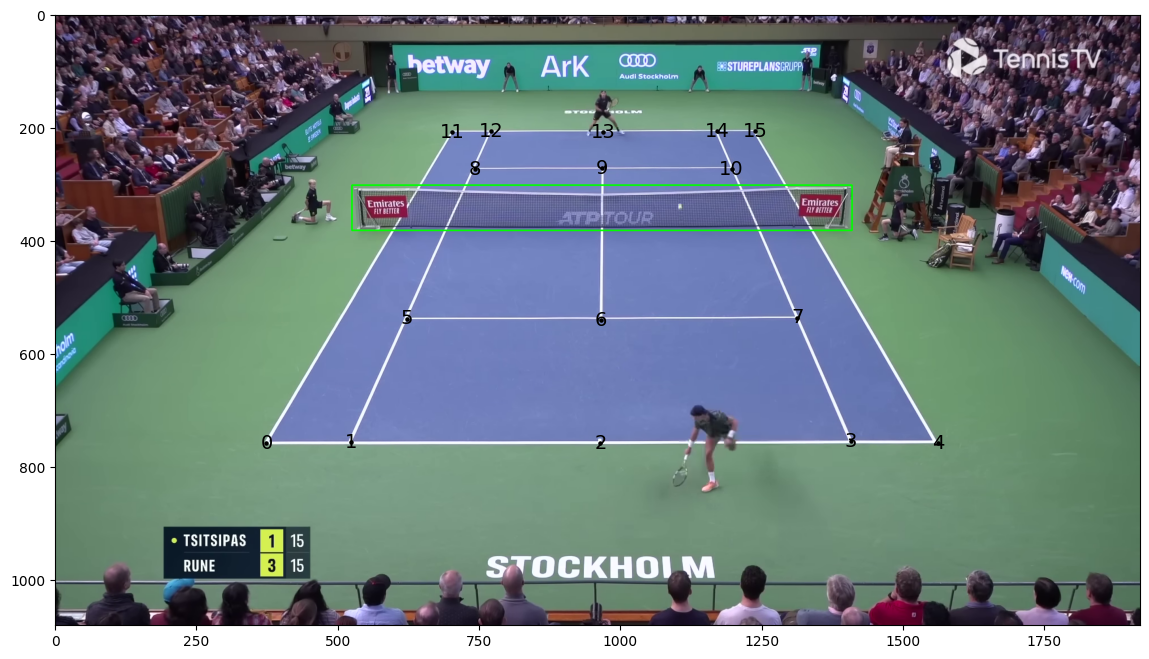

In [43]:
row_index = 43

# Assuming you have a DataFrame called 'df' and a specific row 'row_index' you want to process
row = df_annot.loc[row_index]

# Path and frame num
video_path = row['path_video']
frame_id = row['frame_id']
net_points = row['net']
court_points = row["court"]

# Load video frame
cap, frame = capture_frame(video_path, frame_id)

# Close the video capture
cap.release()


# PLot frame
fig, ax = plot_frame(frame)

# Plot net
ax = plot_net(ax, net_points, frame)

# Plot court
ax = plot_court(ax, court_points)


# Show the plot
plt.show()


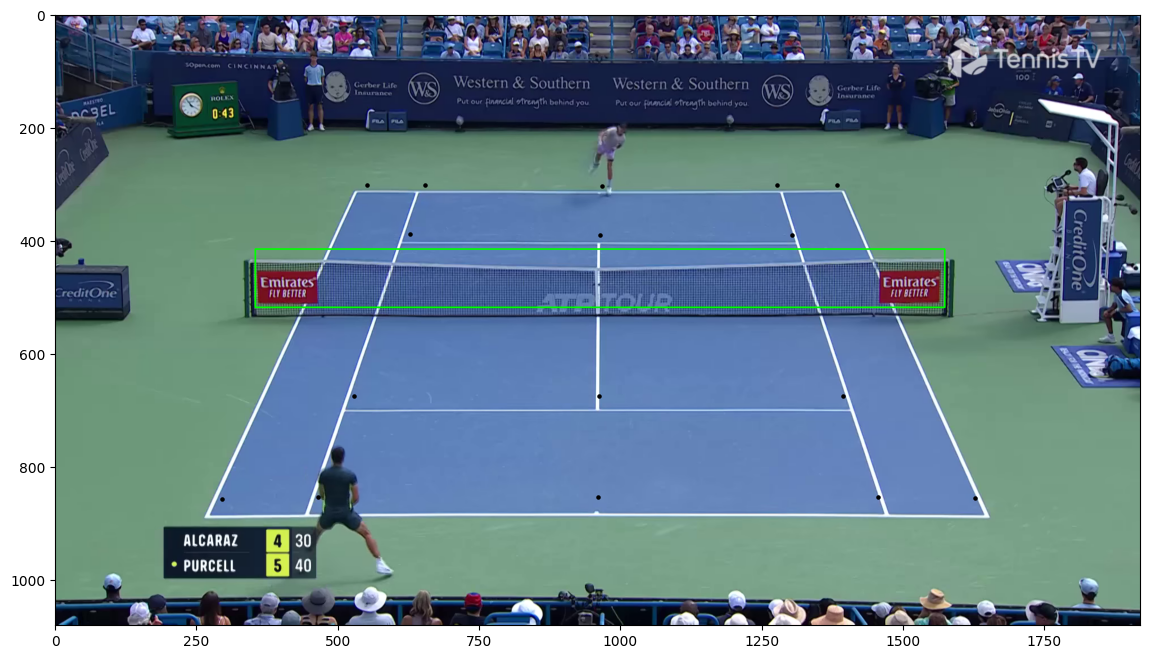

In [149]:
# Load another frame
add_frames = 170 # 1000  # 170
frame_add_id = row['frame_id'] + add_frames

# Load video frame
cap, frame = capture_frame(video_path, frame_add_id)

# Close the video capture
cap.release()

# PLot frame
fig, ax = plot_frame(frame)

# Plot net
ax = plot_net(ax, net_points)

# Plot court
ax = plot_court(ax, court_points)

# Show the plot
plt.show()


In [122]:
frame_add_id

3052